### 分析非法网站和合法网站的ns和ttl情况

* 合法域名和非法域名的ns的ttl时间
* **注意**：这个数据只解析一次域名的cname地址的数据

In [1]:
# encoding:utf-8
from collections import Counter
from pymongo import MongoClient

% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
client = MongoClient('172.29.152.152', 27017)
db = client['eds_last']
domain_col = db['domain_ttl_white_new']
mal_col = db['domain_ttl_new']

In [3]:
def manage_data(records):
    r_count = 0  # 记录数量
    r_counter = Counter()
    for r in records:
        ip_ttl_list = r['data'][0]['ns_ttl']
        if ip_ttl_list:
                r_count += 1
                r_counter[ip_ttl_list[0]] +=1
    return r_count, r_counter

In [4]:
def manage_label(r_counter,domain_count):
    r_counter = r_counter.most_common()
    x = np.arange(len(r_counter))
    y,x_ticks = [],[]
    for i,j in r_counter:
        percent_j = float(j)/domain_count*100
        x_ticks.append(i)
        y.append(percent_j)
#         print i,round(percent_j,2)
    
    return x,y,x_ticks

In [5]:
domain_records = domain_col.find({'data.ips':{'$not': {'$size': 0}}})
mal_records = mal_col.find({'data.ips':{'$not': {'$size': 0}}})
ip_ttl_counter,mal_ip_ttl_counter = Counter(),Counter()
domain_count, mal_count=  0, 0

domain_count, ip_ttl_counter = manage_data(domain_records)
mal_count, mal_ip_ttl_counter = manage_data(mal_records)

print domain_count
print mal_count

x,y,x_ticks = manage_label(ip_ttl_counter,domain_count)
mal_x,mal_y,mal_x_ticks = manage_label(mal_ip_ttl_counter,mal_count)

20542
28849


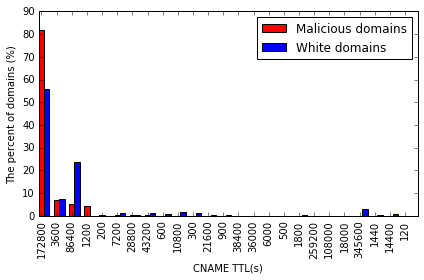

In [6]:
top = 25

## 非法网站的变量内容
mal_y = mal_y[:top]
mal_x = mal_x[:top]
mal_x_ticks = mal_x_ticks[:top]
domain_y = []

for i in mal_x_ticks:
    if ip_ttl_counter[i]:
        domain_y.append(float(ip_ttl_counter[i])/domain_count*100)
    else:
        domain_y.append(0)
    
fig, ax = plt.subplots(figsize=(6, 4))
index = np.arange(top)
bar_width = 0.35

rects1 = ax.bar(mal_x, mal_y, bar_width, color='r', label='Malicious domains')
rects2 = ax.bar(mal_x + bar_width, domain_y, bar_width, color='b', label='White domains')

ax.set_xlabel('CNAME TTL(s)')
ax.set_ylabel('The percent of domains (%)')
ax.set_xticks(mal_x + bar_width / 2)
ax.set_xticklabels(mal_x_ticks,rotation=90)
ax.legend()

fig.tight_layout()
plt.show()

**上图说明**  

* 非法域名cname的TTL时间主要为600s，占所有域名的近50%;而合法域名最多的为300s，占近30%；